In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import plotly.io as pio
pio.renderers.default = "notebook"
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
from utils import get_df, analyze_results, plot_budget_consumption, plot_accuracy

In [28]:
path = "cookiemonster"
df = analyze_results(path, "bias", parallelize=False)
for destination in df.groupby(['destination']).destination.unique():
    if not destination[0].startswith('319'):
        continue
    advertiser = df[df['destination'].isin(destination)]
    plot_accuracy(advertiser)

num queries without idp bias: 0 workload size:  22
num queries without idp bias: 0 workload size:  22
num queries without idp bias: 1 workload size:  22
num queries without idp bias: 1 workload size:  22
num queries without idp bias: 1 workload size:  22
num queries without idp bias: 1 workload size:  22
num queries without idp bias: 1 workload size:  22
num queries without idp bias: 1 workload size:  22
num queries without idp bias: 1 workload size:  22
num queries without idp bias: 1 workload size:  22
num queries without idp bias: 1 workload size:  22
num queries without idp bias: 1 workload size:  22
num queries without idp bias: 1 workload size:  22
num queries without idp bias: 1 workload size:  22
num queries without idp bias: 1 workload size:  22
num queries without idp bias: 1 workload size:  22
num queries without idp bias: 1 workload size:  22
num queries without idp bias: 1 workload size:  22
num queries without idp bias: 1 workload size:  22
num queries without idp bias: 1

In [29]:
df = pd.read_csv('../data/criteo/criteo_query_pool_conversions.csv')
df.head()

,product_age_group,device_type,audience_id,product_gender,product_brand,product_category1,product_category2,product_category3,product_category4,product_category5,...,user_id,conversion_timestamp,conversion_datetime,conversion_day,filter,count,included,epsilon,aggregatable_cap_value,key
0,NaN,7E56C27BFF0305E788DA55A029EC4988,2F0F9415F834C5E483CAF9EECD0728A9,NaN,NaN,7F286560861764CCB93C90B7AA833949,939A40D09BD05A13C32B381245670495,87E33E0563FFE783FB56D01E7E09E692,71EA49120E86E769830E8F99F3771CBD,E1178B3FAE37E3E767143074AAE22C58,...,FD99253C9CAA5EEDE0CB8B590B5A418A,1599439385,2020-09-06 19:43:05,34,-,1.0,True,0.154900,5,1
1,NaN,7E56C27BFF0305E788DA55A029EC4988,69A24ADB8FB0224E72CB9FD46C0A5885,NaN,NaN,7F286560861764CCB93C90B7AA833949,939A40D09BD05A13C32B381245670495,F12DD5F3BC9E9EE69AF2BFF82AF42027,E0A59502390241811FF14D48EBBA178A,B17162DCB9317062B963EE4C65A87677,...,80B994E556C60C96664A1B4B45F4FDC0,1598897383,2020-08-31 13:09:43,28,-,1.0,True,0.270892,5,2
2,NaN,D7D1FB49049702BF6338894757E0D959,ACEBB1033A0E853C11470868111DCD10,NaN,NaN,62D6A49514020FA0B2E434DB0B506005,C1E60A42840668783CE8F9C783D33BD5,AC674A0B8D2DDB049A6F98F45DD3CF64,D490BA2B409F8CDCA99C16B868086C9B,FEEFAC3D74EAD2A1D5A1832803329798,...,F1472C56BD894E4F71952291DE9BCE87,1598904321,2020-08-31 15:05:21,28,-,1.0,True,0.190296,5,3
3,NaN,7E56C27BFF0305E788DA55A029EC4988,NaN,NaN,NaN,7F286560861764CCB93C90B7AA833949,939A40D09BD05A13C32B381245670495,F12DD5F3BC9E9EE69AF2BFF82AF42027,E0A59502390241811FF14D48EBBA178A,B17162DCB9317062B963EE4C65A87677,...,7EA58E979ACADE2AA81F037DA54C142E,1599068983,2020-09-02 12:49:43,30,-,1.0,True,0.270892,5,2
4,NaN,FF2C446555E3822B0E0FC3406116E86D,NaN,NaN,NaN,7F286560861764CCB93C90B7AA833949,939A40D09BD05A13C32B381245670495,87E33E0563FFE783FB56D01E7E09E692,71EA49120E86E769830E8F99F3771CBD,E1178B3FAE37E3E767143074AAE22C58,...,536DEE8592956A530EB4A19545151DBD,1598907671,2020-08-31 16:01:11,28,-,1.0,True,0.154900,5,1


In [32]:
that_guy = df[df.partner_id.isin(['319A2412BDB0EF669733053640B80112'])]
uk = that_guy.groupby('key').key.unique()
uk

key
1      [1]
2      [2]
3      [3]
4      [4]
5      [5]
6      [6]
7      [7]
8      [8]
9      [9]
10    [10]
11    [11]
12    [12]
13    [13]
14    [14]
15    [15]
16    [16]
17    [17]
18    [18]
19    [19]
20    [20]
21    [21]
22    [22]
Name: key, dtype: object

In [7]:
path = "."
df = analyze_results(path, "budget")
df = df.sort_values(by="workload_size", ascending=False).head()
plot_budget_consumption(df)

/mydata/cookiemonster/logs/0402-232917_4aad5f/result.json


KeyboardInterrupt: 

In [230]:
path = "ray/synthetic/budget_consumption_varying_impressions_rate_7"
df = analyze_results(path, "budget")
plot_budget_consumption(df, facet_row="impression_rate")

In [14]:
path = "ray/synthetic/budget_consumption_varying_epoch_granularity"
df = analyze_results(path, "budget")
plot_budget_consumption(df, facet_row="num_days_per_epoch")

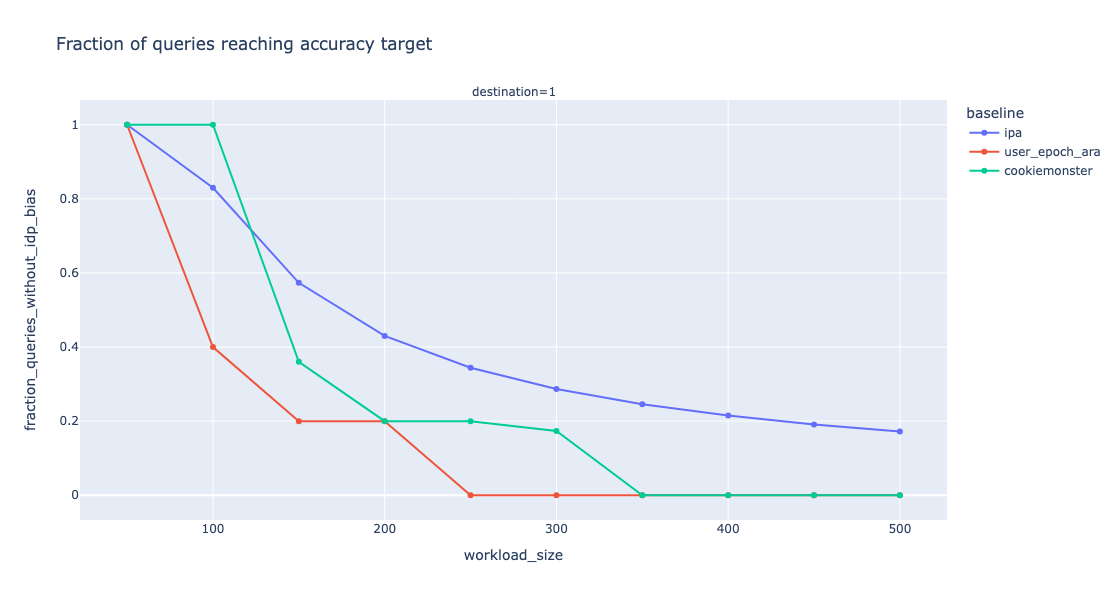

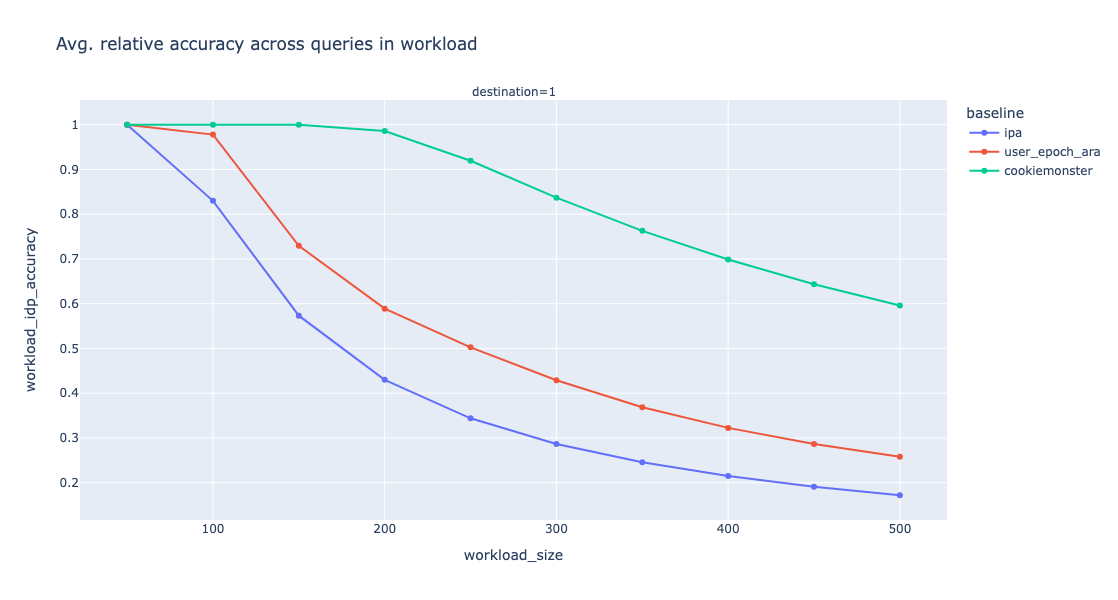

In [35]:
path = "ray/synthetic/bias_varying_workload_size"
df = analyze_results(path, "bias")
plot_accuracy(df)

In [27]:
df

,destination,workload_size,fraction_queries_without_idp_bias,workload_idp_accuracy,baseline,num_days_per_epoch
0,1,400,0.000000,0.322540,user_epoch_ara,7
0,1,50,1.000000,1.000000,user_epoch_ara,7
0,1,150,0.573333,NaN,ipa,7
0,1,200,0.430000,NaN,ipa,7
0,1,200,0.200000,0.986174,cookiemonster,7
0,1,250,0.200000,0.919618,cookiemonster,7
0,1,450,0.191111,NaN,ipa,7
0,1,100,1.000000,1.000000,cookiemonster,7
0,1,250,0.000000,0.502629,user_epoch_ara,7
0,1,50,1.000000,1.000000,cookiemonster,7
